# Denoising Autoencoder

Sticking with the MNIST dataset, we add noise to our data and define and train an autoencoder to _de_-noise the images.

<img src='notebook_ims/autoencoder_denoise.png' width=70%/>



In [ ]:
!pip install -r requirements.txt | grep -v "already"

> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [2]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=20)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 10946824.55it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 55262634.04it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 10772231.93it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|█████████████████████████████████| 4542/4542 [00:00<00:00, 12149571.92it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

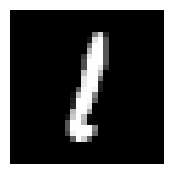

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
# Denoising



>**We'll use noisy images as input and the original, clean images as targets.** 

Below is an example of some of the noisy images I generated and the associated, denoised images.

<img src='notebook_ims/denoising.png' />

## Define Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 16, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
                
        return self.model(x)


# initialize the NN
model = ConvDenoiser()

---
## Training

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

loss and the optimizer:

In [6]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

And now let's train:

In [10]:
# number of epochs to train the model
n_epochs = 30

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in tqdm(
        desc="Training", 
        total=len(data_loaders['train']), 
        iterable=data_loaders['train'],
        ncols=80
    ):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.rand_like(images)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid'],
        ncols=80):
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.rand_like(images)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
            
            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)

            # update running training loss
            val_loss += loss.item()*images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'].dataset)
    val_loss /= len(data_loaders['valid'].dataset)
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 639.24it/s]


Epoch: 1 	Training Loss: 0.007321	Valid Loss: 0.007387


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 636.16it/s]


Epoch: 2 	Training Loss: 0.007285	Valid Loss: 0.007215


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 655.24it/s]


Epoch: 3 	Training Loss: 0.007266	Valid Loss: 0.007339


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 634.21it/s]


Epoch: 4 	Training Loss: 0.007234	Valid Loss: 0.007065


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 604.36it/s]


Epoch: 5 	Training Loss: 0.007214	Valid Loss: 0.007200


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 632.25it/s]


Epoch: 6 	Training Loss: 0.007205	Valid Loss: 0.007025


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 604.69it/s]


Epoch: 7 	Training Loss: 0.007146	Valid Loss: 0.007372


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 642.19it/s]


Epoch: 8 	Training Loss: 0.007153	Valid Loss: 0.007171


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 637.84it/s]


Epoch: 9 	Training Loss: 0.007114	Valid Loss: 0.007150


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 620.81it/s]


Epoch: 10 	Training Loss: 0.007117	Valid Loss: 0.006986


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 641.51it/s]


Epoch: 11 	Training Loss: 0.007098	Valid Loss: 0.006919


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 648.28it/s]


Epoch: 12 	Training Loss: 0.007082	Valid Loss: 0.007015


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 653.55it/s]


Epoch: 13 	Training Loss: 0.007072	Valid Loss: 0.006953


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 628.03it/s]


Epoch: 14 	Training Loss: 0.007042	Valid Loss: 0.007154


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 624.96it/s]


Epoch: 15 	Training Loss: 0.007050	Valid Loss: 0.007054


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 623.04it/s]


Epoch: 16 	Training Loss: 0.007034	Valid Loss: 0.006870


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 667.42it/s]


Epoch: 17 	Training Loss: 0.007003	Valid Loss: 0.006924


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 635.63it/s]


Epoch: 18 	Training Loss: 0.007011	Valid Loss: 0.006923


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 637.94it/s]


Epoch: 19 	Training Loss: 0.006970	Valid Loss: 0.007030


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 634.85it/s]


Epoch: 20 	Training Loss: 0.006995	Valid Loss: 0.006888


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 608.49it/s]


Epoch: 21 	Training Loss: 0.006985	Valid Loss: 0.006963


Validating: 100%|████████████████████████████| 600/600 [00:01<00:00, 576.86it/s]


Epoch: 22 	Training Loss: 0.006956	Valid Loss: 0.006923


Validating: 100%|████████████████████████████| 600/600 [00:00<00:00, 614.20it/s]


Epoch: 23 	Training Loss: 0.006964	Valid Loss: 0.006910


Training:   0%|                            | 1/2400 [01:40<66:59:55, 100.54s/it]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe08d34040><function _MultiProcessingDataLoaderIter.__del__ at 0x7efe08d34040>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe08d34040>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7efe08d34040>

Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/pc/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/home/pc/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/home/pc/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/home/pc/anaconda3

KeyboardInterrupt: 

## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

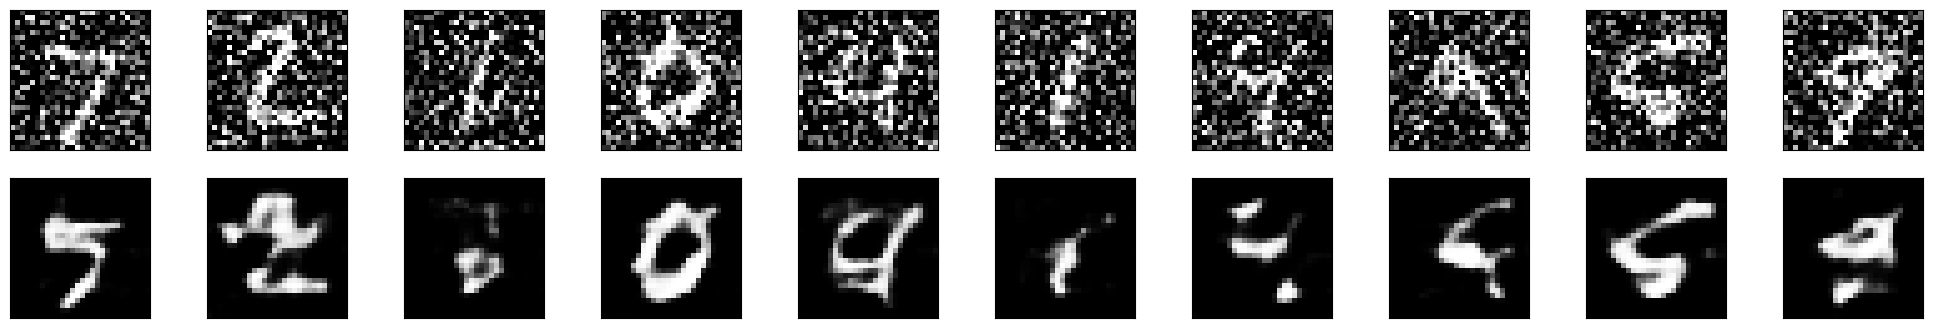

In [11]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])
images, labels = next(dataiter)

# add noise to the test images
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(20, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)